<div class="image-container">
  <img class="image" src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Logo-ITESO-Vertical-SinFondo-png.png" width="300" height="300" style="float: right">
</div>

<p>
    <font style = "font-family:Cambria">          
    <h2><font color="#191970" size = 6 >
       Proyecto: 002 Technical Analysis
    </font></h2>         
    <br>         
    <br> 
    <h3><font size =4>Integrantes:</font></h3> 
    <ul>
        <li>Ricardo Rodriguez Salcedo</li>
        <li>Rodolfo Garcia Palma</li>
        <li>Sebastian Muñoz Baruqui</li>
        <li>Fernando Zepeda Fernandez</li>
        <li>Cesar Gerardo Escobar</li>
    </ul>               
    </font>
</p>


> ## Introducción 

El análisis técnico en los mercados financieros consiste en el examen de datos históricos para prever tendencias futuras en los precios de los activos. Proporciona un marco metodológico para interpretar el comportamiento del mercado, permitiendo la toma de decisiones informadas y la gestión de riesgos. Aunque no se trata de un enfoque infalible, se reconoce como una herramienta valiosa para una amplia gama de operadores del mercado. Diversas estrategias, como EWMA, SMA, ADX, RSI y el Oscilador Estocástico, se emplean con el fin de optimizar estrategias de inversión basadas en el análisis técnico.

### Descripción de parámetros

1. **RSI:**
   - `rsi_window`: Ventana para el cálculo del RSI (entero entre 10 y 50).
   - `rsi_upper_threshold`: Umbral superior del RSI (entero entre 50 y 95).
   - `rsi_lower_threshold`: Umbral inferior del RSI (entero entre 5 y 49).

2. **EWMA:**
   - `ewma_long_window`: Ventana para la media móvil exponencial larga (entero entre 50 y 100).
   - `ewma_short_window`: Ventana para la media móvil exponencial corta (entero entre 5 y 49).

3. **SMA:**
   - `sma_long_window`: Ventana para la media móvil simple larga (entero entre 20 y 50).
   - `sma_short_window`: Ventana para la media móvil simple corta (entero entre 2 y 19).

4. **ADX:**
   - `adx_window`: Ventana para el cálculo del ADX (entero entre 10 y 50).
   - `adx_threshold`: Umbral del ADX (entero entre 15 y 30).

5. **STO:**
   - `sto_window`: Ventana para el cálculo del indicador estocástico (entero entre 10 y 50).
   - `sto_upper_threshold`: Umbral superior del indicador estocástico (entero entre 50 y 95).
   - `sto_lower_threshold`: Umbral inferior del indicador estocástico (entero entre 5 y 49).


> ## Mejor estrategia de trading 

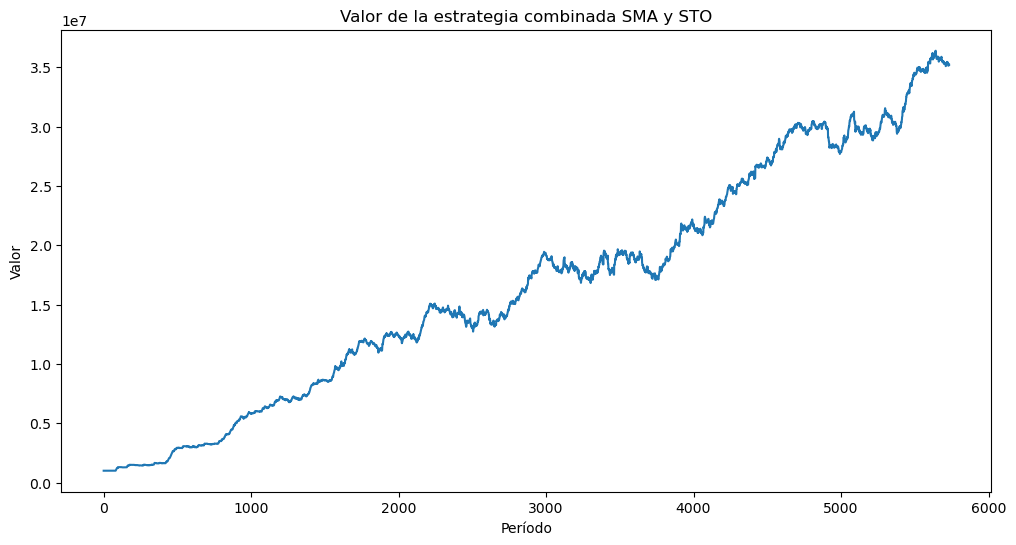

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from utils import Operation

# Cargar el conjunto de datos
df = pd.read_csv('data/aapl_5m_test.csv')

# Crear las columnas para SMA
short_ma = ta.trend.SMAIndicator(df.Close, window=24)
long_ma = ta.trend.SMAIndicator(df.Close, window=14)
df['Short_SMA'] = short_ma.sma_indicator()
df['Long_SMA'] = long_ma.sma_indicator()

# Calcular el oscilador estocástico
stochastic_data = ta.momentum.StochasticOscillator(high=df.High, low=df.Low, close=df.Close, window=10)
df['%K'] = stochastic_data.stoch()
df['%D'] = stochastic_data.stoch_signal()

# Generar señales de compra y venta para SMA
df['SMA_buy_signal'] = (df['Long_SMA'] < df['Short_SMA']) & (df['%K'] < 19)
df['SMA_sell_signal'] = (df['Long_SMA'] > df['Short_SMA']) & (df['%K'] > 81)

# Parámetros óptimos
stop_loss_long = 0.024796600103236185
take_profit_long = 0.38593322012654585
stop_loss_short = 0.49615439857382665
take_profit_short = 0.6340815141615455
n_shares = 95

# Variables de la estrategia
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]

class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares,
                 stop_loss,take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at =  None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

# Ejecutar la estrategia
for i, row in df.iterrows():
    # Cerrar operaciones activas
    temp_operations = []
    for op in active_operations:
        if op.operation_type == 'Long':
            if op.stop_loss > row.Close:  # Cerrar operaciones perdedoras
                cash += row.Close * op.n_shares * (1 - com)
            elif op.take_profit < row.Close:  # Cerrar operaciones con ganancias
                cash += row.Close * op.n_shares * (1 - com)
            else:
                temp_operations.append(op)
        elif op.operation_type == 'Short':
            if op.stop_loss < row.Close:  # Cerrar operaciones perdedoras
                cash -= row.Close * op.n_shares * (1 + com)
            elif op.take_profit > row.Close:  # Cerrar operaciones con ganancias
                cash -= row.Close * op.n_shares * (1 + com)
            else:
                temp_operations.append(op)
    active_operations = temp_operations

    # ¿Tenemos suficiente efectivo?
    if cash > row.Close * n_shares * (1 + com):
        # Señales de compra y venta de SMA
        sma_buy_signal = df.at[i, 'SMA_buy_signal']
        sma_sell_signal = df.at[i, 'SMA_sell_signal']

        # Ejecutar órdenes de compra y venta en corto según las señales
        if sma_buy_signal and row['%K'] < 19:
            active_operations.append(Operation(operation_type='Long',
                                                bought_at=row.Close,
                                                timestamp=row.Timestamp,
                                                n_shares=n_shares,
                                                stop_loss=row.Close * stop_loss_long,
                                                take_profit=row.Close * (1 + take_profit_long)))
            cash -= row.Close * n_shares * (1 + com)
        elif sma_sell_signal and row['%K'] > 81:
            active_operations.append(Operation(operation_type='Short',
                                                bought_at=row.Close,
                                                timestamp=row.Timestamp,
                                                n_shares=n_shares,
                                                stop_loss=row.Close * (1 + stop_loss_short),
                                                take_profit=row.Close * take_profit_short))
            cash += row.Close * n_shares * (1 - com)

    # Valor de la estrategia
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)

# Graficar el valor de la estrategia a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(strategy_value)
plt.title('Valor de la estrategia combinada SMA y STO')
plt.xlabel('Período')
plt.ylabel('Valor')
plt.show()


> ## Conclusiónes